# Pyintegrity: An Open-Source Toolbox for Processing Ultrasonic Pulse-Echo Well Integrity Log Data

### Erlend Magnus Viggen<sup>1</sup>, Anja Diez<sup>2</sup>, Tonni Franke Johansen<sup>2</sup>

<sup>1</sup> Centre for Innovative Ultrasound Solutions and Dept. of Circulation and Medical Imaging, Norwegian University of Science and Technology, Trondheim, Norway
<br/>
<sup>2</sup> Sustainable Communication Technologies, SINTEF Digital, Trondheim, Norway

## Introduction

This Jupyter Notebook is a companion to the article of the same name, published in the proceedings of the SPE Norway Subsurface Conference 2024. It shows how the results of that article can be reproduced using Pyintegrity, and hence also works as a demonstration of the Pyintegrity library itself.

The notebook reads and processes ultrasonic data from a well integrity log file from the open [Volve Data Village dataset](https://data.equinor.com/dataset/Volve). The file in question is `WL_RAW_PROD_AC-AIMG-CCL-GR_2013-06-05_2.DLIS`, from well F-11 B. Like most image log files, this file is on the DLIS file format ([API RP66 v1](https://energistics.org/sites/default/files/RP66/V1/Toc/main.html)). Pyintegrity uses the [dlisio](https://github.com/equinor/dlisio) library to read such files. (If you want to learn more about how to use dlisio to read acoustic well log data, there is [a tutorial article](https://www.researchgate.net/publication/340645995_Getting_started_with_acoustic_well_log_data_using_the_dlisio_Python_library_on_the_Volve_Data_Village_dataset) with [an accompanying Jupyter Notebook](https://github.com/equinor/dlisio-notebooks) available, as well as the [official dlisio documentation](https://dlisio.readthedocs.io/).)

To run this notebook locally, you must first download and install Pyintegrity. Instructions can be found in the repository's `README.md` file.

## Load necessary packages

In [1]:
%matplotlib inline

import os
import copy
import pickle
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from dlisio import dlis
from pyintegrity import Quantity
from pyintegrity.logchannel import LogChannel
from pyintegrity.logparameter import LogParameter

from pyintegrity.pulseecho.processing.w2w1 import process_w2w1
from pyintegrity.pulseecho.processing.abcd import process_abcd
from pyintegrity.pulseecho.processing.t3 import process_T3
from pyintegrity.pulseecho.processing.l1 import process_L1

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# Load data

## Fetch the file

If you do not have the Volve well log file `WL_RAW_PROD_AC-AIMG-CCL-GR_2013-06-05_2.DLIS` downloaded already, the next cell can download it from the Volve Data Village dataset for you, as long as you log in first to fetch your download credentials.

*(The rest of this section is taken from [the aforementioned dlisio tutorial notebook](https://github.com/equinor/dlisio-notebooks/blob/master/acoustic.ipynb); thanks to Erlend Hårstad at Equinor.)*

The Volve data is made publically available by Equinor through Azure BlobStore. In the next cell we download the DLIS file that we intend to work with in this notebook from that BlobStore. In order to do that, we first need to head over to https://data.equinor.com/dataset/Volve to fetch a sas token (our credentials). After logging in with a Microsoft account and accepting the terms and conditions, scroll to the bottom of the page and copy the sas token from the shared access signature URI. Note that the sas token is only the last part of that URI, i.e. everything _after_ the question mark (excluding the question mark itself). Paste it into the `sas` variable in the cell below and run it.

## Load USIT log data from file

Using the dlisio library, we can open the DLIS file and extract information from it. Because the log file was recorded using the USIT logging tool, we use the Pyintegrity's `usit` subpackage to import data.

1. Load the `THNO` log parameter, which specifies the nominal casing thickness.
    * This is loaded as a `LogParameter` object, which is Pyintegrity's representation of DLIS log parameters. `LogParameter` objects have names (i.e., mnemonics such as THNO), descriptions, and values taken from the log file. If the values are numerical, they are represented internally as `Quantity` objects from the Pint library to facilitate unit conversion.

2. Load all the USIT-specific log channels (as `LogChannel` objects organized by frame and mnemonic) and parameters (as `LogParameter` objects).
    * A DLIS frame is a collection of log channels that are all indexed by the same axis (typically depth) and therefore have the same axial (depth) resolution.
    * The `LogChannel` class is Pyintegrity's representation of DLIS log channels. `LogChannel` objects have a data array with axes (via the Xarray library) and units (via the pint-xarray library) and support unit conversion. They also have names (mnemonics) and descriptions taken from the log file.

3. Load the USIT waveforms and related information as a `PulseEchoSeries` object.
    * The `PulseEchoSeries` class is a subclass of `LogChannel`. `PulseEchoSeries` objects hold the measured waveforms as 3D depth-angle-time arrays as well as auxiliary data about the properties of the casing and the inner fluid. These objects are used as input for the processing algorithms.

In [2]:
import pyintegrity.pulseecho.usit as usit

filepath = 'WL_RAW_PROD_AC-AIMG-CCL-GR_2013-06-05_2.DLIS'

with dlis.load(filepath) as files:   # Loads a DLIS physical file that can contain one or more DLIS logical files
    file = files[0]                  # In this case, there is only one logical file in the physical file
    thickness_nominal = LogParameter(file.object('PARAMETER', 'THNO'))
    frame_logchannels, parameters = usit.get_usit_data(file)
    series = usit.get_usit_series(file)

What is the nominal thickness?

In [3]:
print('Nominal thickness parameter:')
print(thickness_nominal)
print()
print(f'{thickness_nominal.values.to("in"):.3f~P} = {thickness_nominal.values.to("cm"):.3f~P}')

Nominal thickness parameter:
THNO = 0.539080798625946 in [Nominal Thickness of Casing]

0.539 in = 1.369 cm


Having loaded these USIT log channels from the file, we can demonstrate how these can be easily plotted using the `LogChannel` class' plotting facilities.

Here, we use the following 2D (depth-by-angle) channels:

* **AIBK**: The acoustic impedance behind the casing
* **T2BK**: The casing thickness deviation from the nominal value. Adding `thickness_nominal` gives us the thickness.

These channels are found in frame `60B`, which has a depth resolution of 60*0.1 in = 6 in.

Log impedance units: MRayl
Log thickness units: in
New thickness units: cm


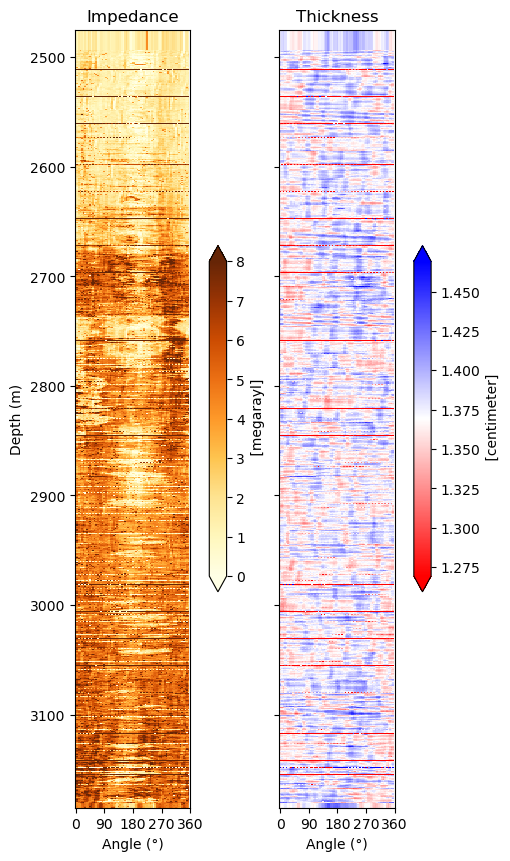

In [4]:
impedance_ref = frame_logchannels['60B']['AIBK'].copy()
thickness_ref = frame_logchannels['60B']['T2BK'].copy()

print(f'Log impedance units: {impedance_ref.data.pint.units:~P}')
print(f'Log thickness units: {thickness_ref.data.pint.units:~P}')

# Add nominal thickness and convert to centimetres
thickness_ref.data = (thickness_ref.data + thickness_nominal.values).pint.to('cm')
print(f'New thickness units: {thickness_ref.data.pint.units:~P}')

fig, axes = plt.subplots(figsize=(5, 8.5), ncols=2, sharex=True, sharey=True, constrained_layout=True)

ax = axes[0]
impedance_ref.plot_in(ax, vmin=0, vmax=8, cmap='YlOrBr', add_colorbar=True)
ax.set_ylabel('Depth (m)')
ax.set_title('Impedance')

ax = axes[1]
vmin, vmax = thickness_nominal.values.to('cm').magnitude + 0.1*np.array([-1, 1])
thickness_ref.plot_in(ax, vmin=vmin, vmax=vmax, cmap='bwr_r', add_colorbar=True)
ax.set_ylabel('')
ax.set_title('Thickness')

for ax in axes:
    ax.set_xticks([0, 90, 180, 270, 360])
    ax.set_xlabel('Angle (°)')

## Waveform examples

So how do the ultrasonic pulse-echo measurements in the log file look like? We can extract two from our `PulseEchoSeries` object, one with a fluid behind the casing (at 2552.55 m, in the free-pipe section) and one with a solid behind the casing (at 2700.07 m, in the cemented section).

For each measurement, we:
* Extract the waveform time axis (in µs)
* Extract the waveform (dimensionless)
* Calculate the waveform envelope via the Hilbert transform (dimensionless)
* Calculate the frequency spectrum for the entire waveform

/Users/erlenv/mambaforge/envs/pyintegrity2/lib/python3.11/site-packages/xarray/core/variable.py:306: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/var/folders/0k/6fvjhp7x2659gf4_pbq0zkj40000gp/T/ipykernel_31276/68570095.py:49: RuntimeWarning: divide by zero encountered in log10
  ax.plot(1e-3*f_spec, 20*np.log10(np.abs(spec_fluid)))


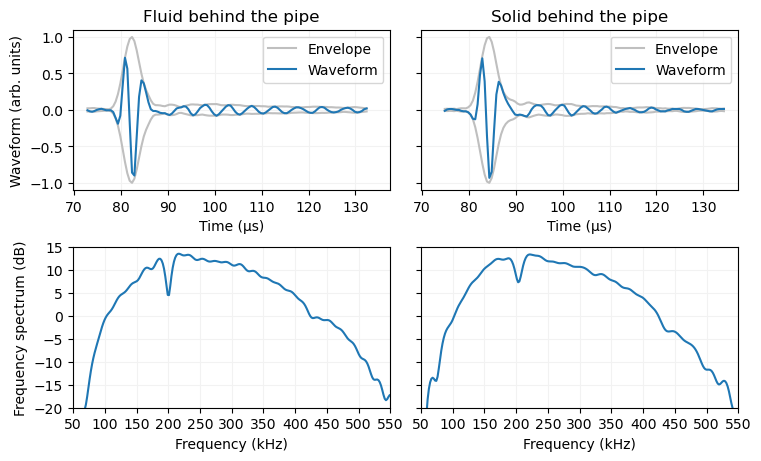

In [5]:
from scipy.signal import hilbert
from scipy.fft import rfft, rfftfreq

z_fluid = 2552.55
z_solid = 2700.07

# Get absolute time axes, waveforms, and waveform envelopes
t_fluid = series.t_abs.sel(z=z_fluid, phi=0, method='nearest').pint.to('µs')
t_solid = series.t_abs.sel(z=z_solid, phi=0, method='nearest').pint.to('µs')
wf_fluid = series.data.sel(z=z_fluid, phi=0, method='nearest')
wf_solid = series.data.sel(z=z_solid, phi=0, method='nearest')
env_fluid = np.abs(hilbert(wf_fluid))
env_solid = np.abs(hilbert(wf_solid))

# If we want relative time (time after first sample)
#t_fluid = t_fluid - min(t_fluid)
#t_solid = t_solid - min(t_solid)

# Normalize waveforms and envelopes
wf_fluid, env_fluid = np.array((wf_fluid, env_fluid)) / np.max(env_fluid)
wf_solid, env_solid = np.array((wf_solid, env_solid)) / np.max(env_solid)

# Calculate frequency spectra
n_fft = 1024
f_spec = rfftfreq(n_fft, 0.5e-6)
spec_fluid = rfft(wf_fluid.data, n=n_fft)
spec_solid = rfft(wf_solid.data, n=n_fft)

fig, axes = plt.subplots(figsize=(7.5, 4.5), ncols=2, nrows=2, sharex='row', sharey='row', constrained_layout=True)

env_opts = dict(color='0.75')   # Envelope plot options

ax = axes[0,0]   # Fluid waveform
ax.plot(t_fluid, -env_fluid, **env_opts)
ax.plot(t_fluid, env_fluid, **env_opts, label='Envelope')
ax.plot(t_fluid, wf_fluid, label='Waveform')
ax.set_title('Fluid behind the pipe')
ax.set_ylabel('Waveform (arb. units)')
ax.legend()

ax = axes[0,1]   # Solid waveform
ax.plot(t_solid, -env_solid, **env_opts)
ax.plot(t_solid, env_solid, **env_opts, label='Envelope')
ax.plot(t_solid, wf_solid, label='Waveform')
ax.set_title('Solid behind the pipe')
ax.legend()

ax = axes[1, 0]   # Fluid frequency spectrum
ax.plot(1e-3*f_spec, 20*np.log10(np.abs(spec_fluid)))
ax.set_ylabel('Frequency spectrum (dB)')

ax = axes[1, 1]   # Solid frequency spectrum
ax.plot(1e-3*f_spec, 20*np.log10(np.abs(spec_solid)))
ax.set_ylim(-20, 15)
ax.set_xlim(50, 550)

for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        ax = axes[i, j]
        ax.grid(True, color='0.95')
        if i == 0: ax.set_xlabel('Time (µs)')
        if i == 1:
            ax.set_xlabel('Frequency (kHz)')
            ax.set_yticks(range(-20, 16, 5))
            ax.set_xticks(range(50, 600, 50))

In these two waveforms, the first strong pulse (representing the reflection from the interface between the inner liquid and the pipe) is almost identical. The main difference lies in the resonance tail, which decays faster when there is a fluid behind the pipe because the steel pipe has a better impedance match with the solid than with the fluid, allowing more acoustic energy to ‘disappear’ into the outer material.

Most of the frequency spectrum contents originate in the first strong pulse. The dip in the frequency spectrum is caused by interference with the resonance tail. Because there is less energy in the resonance tail with a solid behind the pipe, the dip is not as deep in that case as it is for a fluid.

# Apply processing algorithms

Now that we have the waveforms and other relevant information available as `PulseEchoSeries` objects, we can apply Pyintegrity's different processing algorithms to find estimates of impedance and/or wall thickness. These processing algorithms differ in which windows they take of the waveforms and what they do with the data inside those windows.

## Trim data in depth

The processing algorithms take a while to run and the article only covers a 300 m interval. We can discard data outside a given depth interval to save time and energy on processing data that we do not need.

Here, we trim both the `PulseEchoSeries` object (which contains the ultrasonic waveforms) and the USIT log channels.

In [6]:
trim_interval = (2500, 2800)   # The 300 m inverval used in the article
#trim_interval = (2500, 2510)   # A shorter 10 m interval for quick testing

series = series.get_depth_section(*trim_interval)

for frame in frame_logchannels.values():
    for name, channel in frame.items():
        frame[name] = channel.get_depth_section(*trim_interval)

## W2/W1 algorithm

The W2/W1 implementation has the following optional arguments:
* **use_envelope:** Whether to perform W2/W1 processing on the waveform envelope or the rectified waveform.
* **w2w1_fp:** Optional free-pipe W2/W1 value to use for normalization.
* **interval_fp:** Optional free-pipe interval to calculate `w2w1_fp` from if it is not specified.
* **impedance_fp:** The reference impedance value in the free-pipe interval.
* **factor_a:** Parameter for calculating impedance from normalized W2/W1; corresponds to A in Catala et al. (1987).
* **factor_b:** Parameter for calculating impedance from normalized W2/W1; corresponds to B in Catala et al. (1987).

*Note that the W2/W1 algorithm does not provide thickness estimates!*

In [7]:
interval_fp = (2500, 2550)
impedance_fp = impedance_ref.data.sel(z=slice(*interval_fp)).median().data
B = Quantity(3.25, 'kg/mm^2/s')

result_w2w1 = process_w2w1(series, use_envelope=False, interval_fp=interval_fp, impedance_fp=impedance_fp, factor_b=B)

/Users/erlenv/Documents/Post-doc/Code/ultrasonic-processing-for-well-integrity/src/pyintegrity/pulseecho/processing/w2w1.py:237: RuntimeWarning: divide by zero encountered in log
  return impedance_fp - factor_c * np.log(w2w1_cal)


## T3 algorithm

The T3 algorithm implementation has the following optional arguments:
* **interval_f:** Specifies the range in Hz of the frequency search window around the resonance frequency expected from the nominal thickness.
* **limits_windows:** Normalisation window and processing window half-widths, specified in wave periods (which are calculated from the expected resonance frequency).
* **fft_scale:** Resolution scaling factor of the frequency spectrum. Higher values lead to more accurate results and higher processing time.

***NOTE:*** *The T3 algorithm implementation is processing intensive and may take around an hour to run on the 300 m interval.*

In [8]:
if os.path.exists('result_t3.pkl'):          # If previous results are stored,
    with open('result_t3.pkl', 'rb') as f:   # open the file and
        result_t3 = pickle.load(f)           # load them instead

else:                                        # Otherwise,
    result_t3 = process_T3(series)           # rerun the processing,
    with open('result_t3.pkl', 'wb') as f:   # open a new file and
        pickle.dump(result_t3, f)            # store the results there.

## ABCD algorithm

The Pyintegrity implementation of the ABCD algorithm has no optional arguments.

In [9]:
if os.path.exists('result_abcd.pkl'):
    with open('result_abcd.pkl', 'rb') as f:
        result_abcd = pickle.load(f)

else:
    result_abcd = process_abcd(series)
    with open('result_abcd.pkl', 'wb') as f:
        pickle.dump(result_abcd, f)

/Users/erlenv/Documents/Post-doc/Code/ultrasonic-processing-for-well-integrity/src/pyintegrity/pulseecho/processing/abcd.py:212: RuntimeWarning: divide by zero encountered in _res_Spec
  Ha_Rwin_dB = _res_Spec(tstart,tstop,Nfft,waveforms)   # pylint: disable=typecheck
/Users/erlenv/Documents/Post-doc/Code/ultrasonic-processing-for-well-integrity/src/pyintegrity/pulseecho/processing/abcd.py:303: RuntimeWarning: invalid value encountered in _get_Sw
  S_w_mod=_get_Sw(data_mod,tstart,tstop)   # pylint: disable=typecheck


 ** On entry to DLASCLS parameter number  4 had an illegal value
 ** On entry to DLASCLS parameter number  4 had an illegal value
 ** On entry to DLASCLS parameter number  4 had an illegal value
 ** On entry to DLASCLS parameter number  4 had an illegal value
 ** On entry to DLASCLS parameter number  4 had an illegal value
 ** On entry to DLASCLS parameter number  4 had an illegal value
 ** On entry to DLASCLS parameter number  4 had an illegal value
 ** On entry to DLASCLS parameter number  4 had an illegal value
 ** On entry to DLASCLS parameter number  4 had an illegal value
 ** On entry to DLASCLS parameter number  4 had an illegal value


/Users/erlenv/Documents/Post-doc/Code/ultrasonic-processing-for-well-integrity/src/pyintegrity/pulseecho/processing/abcd.py:299: RuntimeWarning: invalid value encountered in _find_reflection
  T_peak_new = _find_reflection(data_mod,f_exp.magnitude,t[0],dt.magnitude,axis=1)   # pylint: disable=typecheck


 ** On entry to DLASCLS parameter number  4 had an illegal value
 ** On entry to DLASCLS parameter number  4 had an illegal value
 ** On entry to DLASCLS parameter number  4 had an illegal value
 ** On entry to DLASCLS parameter number  4 had an illegal value
 ** On entry to DLASCLS parameter number  4 had an illegal value
 ** On entry to DLASCLS parameter number  4 had an illegal value
 ** On entry to DLASCLS parameter number  4 had an illegal value
 ** On entry to DLASCLS parameter number  4 had an illegal value
 ** On entry to DLASCLS parameter number  4 had an illegal value
 ** On entry to DLASCLS parameter number  4 had an illegal value
 ** On entry to DLASCLS parameter number  4 had an illegal value
 ** On entry to DLASCLS parameter number  4 had an illegal value
 ** On entry to DLASCLS parameter number  4 had an illegal value
 ** On entry to DLASCLS parameter number  4 had an illegal value
 ** On entry to DLASCLS parameter number  4 had an illegal value
 ** On entry to DLASCLS p

## L1 algorithm

The L1 algorithm implementation has the following optional arguments:
* **interval_f:** Specifies the range in Hz of the frequency search window around the resonance frequency expected from the nominal thickness.
* **limits_windows:** Initial pulse window half-width, and the start and end points of the L1 window, all specified in expected resonance wave periods.
* **fft_scale:** Resolution scaling factor of the frequency spectrum. Higher values lead to more accurate results and higher processing time.

In [10]:
if os.path.exists('result_l1.pkl'):
    with open('result_l1.pkl', 'rb') as f:
        result_l1 = pickle.load(f)

else:
    result_l1 = process_L1(series, limits_windows=(1.5, 3, 12))
    with open('result_l1.pkl', 'wb') as f:
        pickle.dump(result_l1, f)

# Investigate processing results

With the processing algorithms finished running, it's time to investigate the results.

## Prepare plotting functions

These plotting functions create a side-by-side comparison of thickness or impedance estimates.

In [11]:
def plot_thickness_estimates(thickness_ref: LogChannel,
                             thickness_t3: LogChannel,
                             thickness_abcd: LogChannel,
                             thickness_l1: LogChannel,
                             **kwargs) -> tuple[plt.Figure, np.ndarray[plt.Axes]]:
    
    fig, axes = plt.subplots(figsize=(6.5, 8.5), ncols=4, sharex=True, sharey=True, constrained_layout=True)
    vmin, vmax = thickness_nominal.values.to('cm').magnitude + 0.1*np.array([-1, 1])
    
    ax = axes[0]
    thickness_ref.plot_in(ax, vmin=vmin, vmax=vmax, cmap='bwr_r', add_colorbar=False, **kwargs)
    ax.set_ylabel('Depth (m)')
    ax.set_title('Ref. (T$^3$)')

    ax = axes[1]
    thickness_t3.to('cm').plot_in(ax, vmin=vmin, vmax=vmax, cmap='bwr_r', add_colorbar=False, **kwargs)
    ax.set_ylabel('')
    ax.set_title('T$^3$')

    ax = axes[2]
    thickness_abcd.to('cm').plot_in(ax, vmin=vmin, vmax=vmax, cmap='bwr_r', add_colorbar=False, **kwargs)
    ax.set_ylabel('')
    ax.set_title('ABCD')

    ax = axes[3]
    thickness_l1.to('cm').plot_in(ax, vmin=vmin, vmax=vmax, cmap='bwr_r', add_colorbar=True, **kwargs,
                                  cbar_kwargs=dict(label='Pipe thickness (cm)', aspect=50))
    ax.set_ylabel('')
    ax.set_title('L1')

    ax.set_ylim(*trim_interval[::-1])
    ax.set_xticks([0, 90, 180, 270, 360])
    ax.set_yticks(range(trim_interval[0], trim_interval[1]+1, 10));
    for ax in axes:
        ax.set_xlabel('Azimuth (°)')
        ax.tick_params(axis='both', labelsize=9)

    cbar = fig.get_axes()[-1]
    cbar.tick_params(axis='y', labelsize=9)

    return fig, axes


def plot_impedance_estimates(impedance_ref: LogChannel,
                             impedance_w2w1: LogChannel,
                             impedance_t3: LogChannel,
                             impedance_abcd: LogChannel,
                             impedance_l1: LogChannel,
                             **kwargs) -> tuple[plt.Figure, np.ndarray[plt.Axes]]:
    
    fig, axes = plt.subplots(figsize=(7.5, 8.5), ncols=5, sharex=True, sharey=True, constrained_layout=True)
    vmin, vmax = 0, 8
    
    ax = axes[0]
    impedance_ref.plot_in(ax, vmin=vmin, vmax=vmax, cmap='YlOrBr', add_colorbar=False, **kwargs)
    ax.set_ylabel('Depth (m)')
    ax.set_title('Ref. (T$^3$)')

    ax = axes[1]
    impedance_w2w1.plot_in(ax, vmin=vmin, vmax=vmax, cmap='YlOrBr', add_colorbar=False, **kwargs)
    ax.set_ylabel('')
    ax.set_title('W2/W1')

    ax = axes[2]
    impedance_t3.plot_in(ax, vmin=vmin, vmax=vmax, cmap='YlOrBr', add_colorbar=False, **kwargs)
    ax.set_ylabel('')
    ax.set_title('T$^3$')

    ax = axes[3]
    impedance_abcd.plot_in(ax, vmin=vmin, vmax=vmax, cmap='YlOrBr', add_colorbar=False, **kwargs)
    ax.set_ylabel('')
    ax.set_title('ABCD')

    ax = axes[4]
    impedance_l1.plot_in(ax, vmin=vmin, vmax=vmax, cmap='YlOrBr', add_colorbar=True, **kwargs,
                         cbar_kwargs=dict(label='Acoustic impedance (MRayl)', aspect=50))
    ax.set_ylabel('')
    ax.set_title('L1')

    ax.set_ylim(*trim_interval[::-1])
    ax.set_xticks([0, 90, 180, 270, 360])
    ax.set_yticks(range(trim_interval[0], trim_interval[1]+1, 10));
    for ax in axes:
        ax.set_xlabel('Azimuth (°)')
        ax.tick_params(axis='both', labelsize=9)

    cbar = fig.get_axes()[-1]
    cbar.tick_params(axis='y', labelsize=9)

    return fig, axes

## Plot uncorrected estimates

The algorithms are implemented closely following the original sources. However, it is well-known (see e.g. Hayman et al. 1991) that such algorithms provide biased estimates that require corrections to make them more accurate. Let's compare the uncorrected estimates of thickness and impedance with the reference estimates.

### Thickness

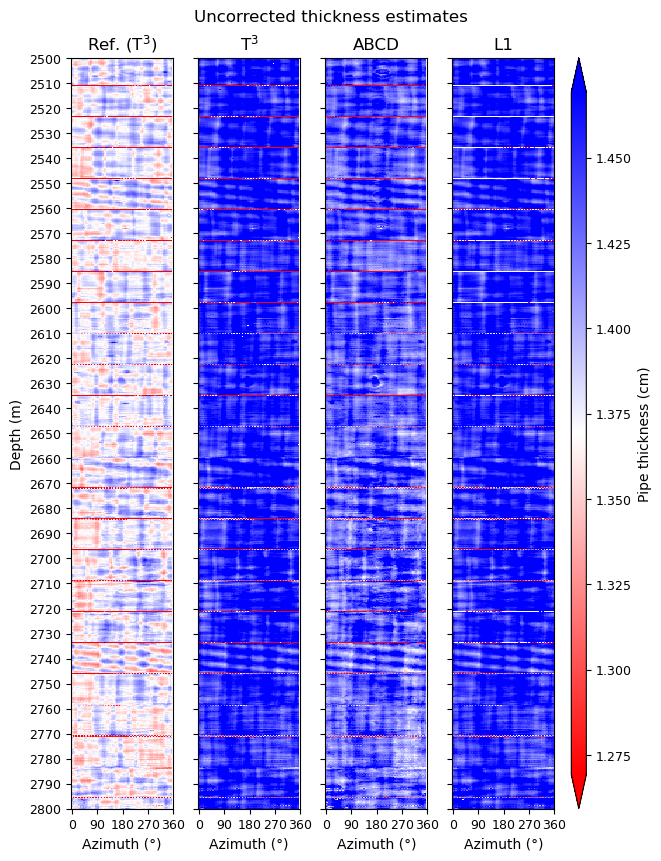

In [12]:
fig, axes = plot_thickness_estimates(thickness_ref, result_t3.thickness, result_abcd.thickness, result_l1.thickness)
fig.suptitle('Uncorrected thickness estimates');

The colourmap is chosen such that white corresponds to the nominal thickness value. Without correction, the different processing algorithms all clearly overestimate the pipe thickness.

### Impedance

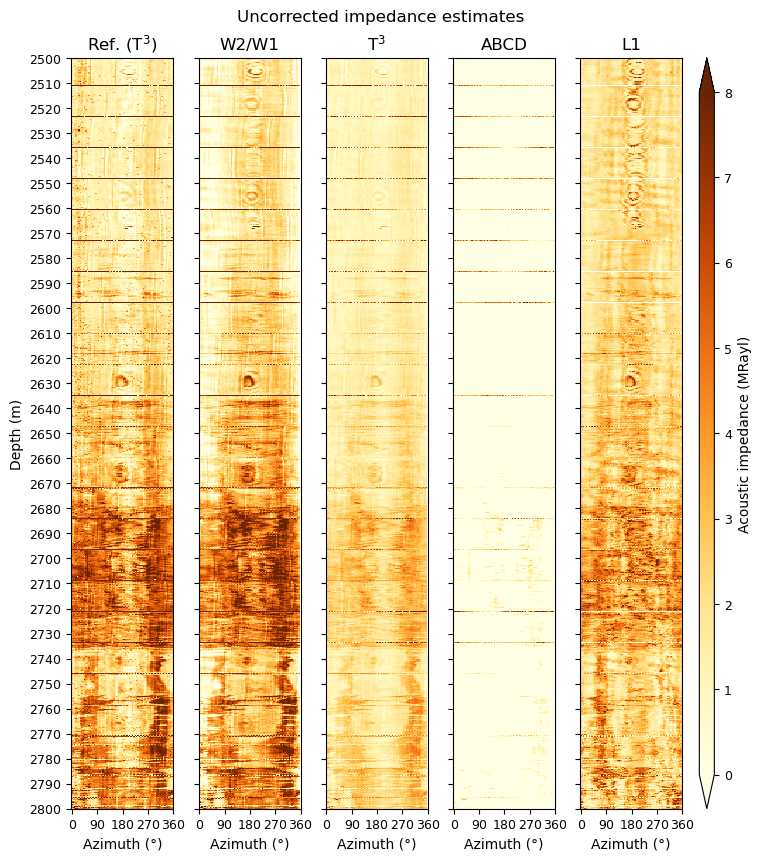

In [13]:
fig, axes = plot_impedance_estimates(impedance_ref, result_w2w1.impedance, result_t3.impedance, result_abcd.impedance, result_l1.impedance)
fig.suptitle('Uncorrected impedance estimates');

The impedance estimates are more varying. With W2/W1, we set `factor_b` to make the initial estimates reasonable, but Pyintegrity's T3 and especially ABCD implementations underestimate the impedance.

## Plot equalized estimates

Clearly, the initial algorithm estimates must be corrected to correspond well to the reference. In general, these corrections can be functions of known parameters such as the initial impedance and thickness estimates, material properties of the inner fluid, nominal pipe thickness, etc. However, these corrections must be computed by careful analysis of how each algorithm's estimation error is affected by the values of such parameters, using an extensive dataset where all geometric and material parameters are accurately known.

In this demo, we use a much simpler approach, which assumes that we have a pre-corrected log channel that we want to match our estimates with. While we could use techniques such as [histogram matching](https://en.wikipedia.org/wiki/Histogram_matching), we use a simpler approach where we scale and shift each estimate to match two of its percentiles with the same percentiles of the reference log channel.

In [14]:
thickness_ref = frame_logchannels['60B']['T2BK'].copy()
thickness_ref.data = (thickness_ref.data + thickness_nominal.values).pint.to('cm')
thickness_t3 = result_t3.thickness.to('cm').equalize_by_percentiles(thickness_ref)
thickness_abcd = result_abcd.thickness.to('cm').equalize_by_percentiles(thickness_ref)
thickness_l1 = result_l1.thickness.to('cm').equalize_by_percentiles(thickness_ref)

impedance_ref = frame_logchannels['60B']['AIBK'].copy()
impedance_w2w1 = result_w2w1.impedance.equalize_by_percentiles(impedance_ref)
impedance_t3 = result_t3.impedance.equalize_by_percentiles(impedance_ref)
impedance_abcd = result_abcd.impedance.equalize_by_percentiles(impedance_ref)
impedance_l1 = result_l1.impedance.equalize_by_percentiles(impedance_ref)

### Thickness

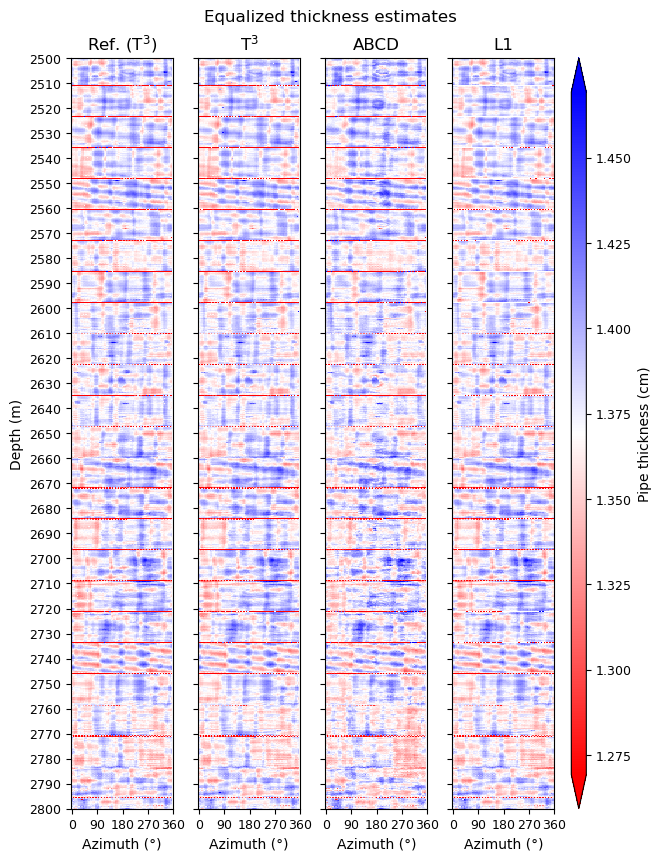

In [15]:
fig, axes = plot_thickness_estimates(thickness_ref, thickness_t3, thickness_abcd, thickness_l1)
fig.suptitle('Equalized thickness estimates');

### Impedance

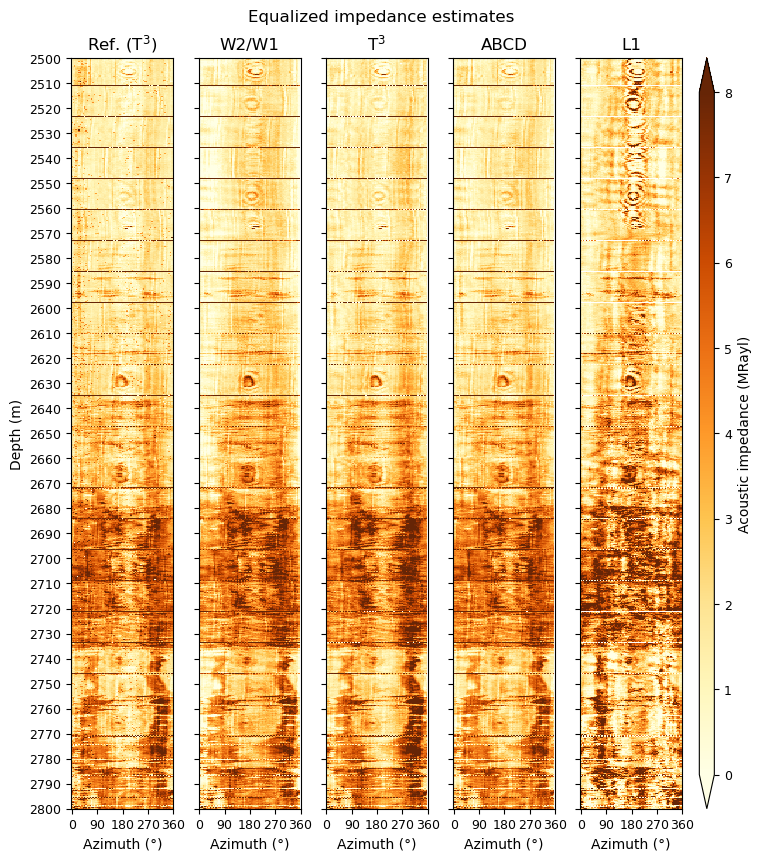

In [16]:
fig, axes = plot_impedance_estimates(impedance_ref, impedance_w2w1, impedance_t3, impedance_abcd, impedance_l1)
fig.suptitle('Equalized impedance estimates');

## Make pair plots of processing results

To make more quantitative comparisons between the processing algorithms' equalized outputs, we can make grids of pair plots. Each off-diagonal plot represents the joint distribution of the estimates found by a pair of processing algorithms, and each diagonal plot shows a histogram of a processing algorithm's estimates.

To facilitate making these pair plots, we use the Seaborn library's `PairGrid` function, which requires representing the data as Pandas `DataFrame` objects.

In [17]:
import seaborn as sns
import pandas as pd

df_impedance = pd.DataFrame({'Ref. (T$^3$) imped.': impedance_ref.array.flatten(),
                             'W2/W1 imped.': impedance_w2w1.array.flatten(),
                             'T$^3$ imped.': impedance_t3.array.flatten(),
                             'ABCD imped.': impedance_abcd.array.flatten(),
                             'L1 imped.': impedance_l1.array.flatten()})

df_thickness = pd.DataFrame({'Ref. (T$^3$) thick.': thickness_ref.array.flatten(),
                             'T$^3$ thick.': thickness_t3.array.flatten(),
                             'ABCD thick.': thickness_abcd.array.flatten(),
                             'L1 thick.': thickness_l1.array.flatten()})

def pairgrid_hist2d(x, y, **kwargs):
    """2D histogram plotting funciton to be passed as an argument to `pairgrid.map_offdiag`

    Args:
        x: Array of values along the x axis
        y: Array of values along the y axis
        kwargs: Keyword arguments passed on to plt.hist2d
    """
    metric = kwargs.pop('metric') if 'metric' in kwargs else None
    if 'cmap' in kwargs:
        cmap = kwargs.pop('cmap')
        kwargs.pop('color')
    else:
        cmap = sns.light_palette(kwargs.pop("color"), as_cmap=True)
    if isinstance(cmap, str):
        cmap = mpl.colormaps[cmap]
    cmap = copy.copy(cmap)
    cmap.set_bad(cmap.colors[0])
    plt.hist2d(x, y, cmap=cmap, cmin=1, rasterized=True, **kwargs)

    plt.grid(True, color='0.5', alpha=0.25)

    if metric == 'mae':
        interval = kwargs['range'][0]
        mask = (x >= interval[0]) * (x <= interval[1]) * (y >= interval[0]) * (y <= interval[1])
        mae = np.mean(np.abs(x[mask] - y[mask]))
        plt.text(s=f'MAD = {mae:.4f}', x=interval[1], y=interval[0], ha='right', va='bottom',
                 color='white', size=7)

/Users/erlenv/mambaforge/envs/pyintegrity2/lib/python3.11/site-packages/pandas/core/construction.py:629: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.array(data, copy=copy)


### Thickness

Build a pair grid and add red ellipses in the plots of reference T3 vs. Pyintegrity's T3 to mark repeated values in the reference results.

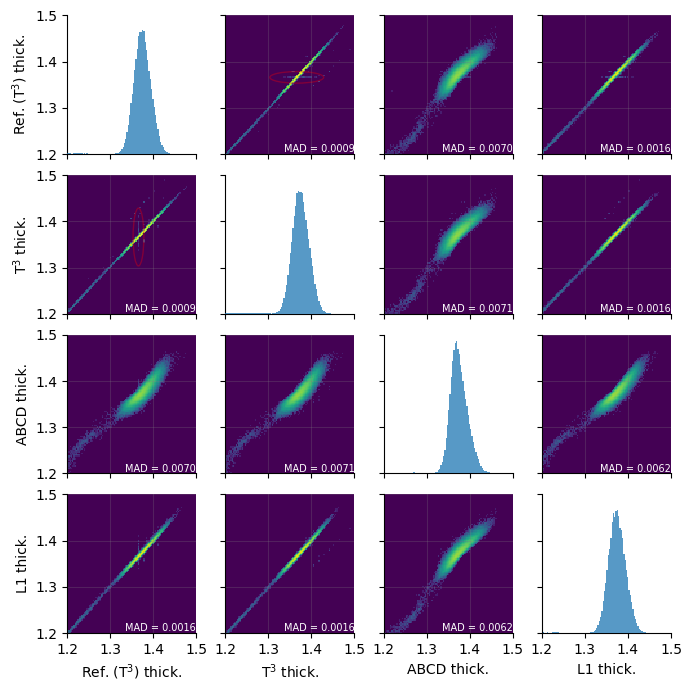

In [18]:
binrange = (1.2, 1.5)

pairgrid = sns.PairGrid(df_thickness, height=1.75)
pairgrid.map_diag(sns.histplot, binrange=binrange, bins=100, edgecolor=None)
pairgrid.map_offdiag(pairgrid_hist2d, bins=100, range=[binrange, binrange], metric='mae',
                     norm=mpl.colors.LogNorm(), cmap='viridis')
pairgrid.set(xticks=[1.2, 1.3, 1.4, 1.5], yticks=[1.2, 1.3, 1.4, 1.5])

axes = pairgrid.figure.get_axes()
axes[1].add_artist(Ellipse(xy=[1.36597, 1.36597], width=0.125, height=0.025, ec='red', fill=False, alpha=0.33))
axes[4].add_artist(Ellipse(xy=[1.36597, 1.36597], width=0.025, height=0.125, ec='red', fill=False, alpha=0.33))

pairgrid.tight_layout()

### Impedance

Build a pair grid and add red ellipses in the plots of reference T3 vs. Pyintegrity's T3 to mark repeated values in the reference results.

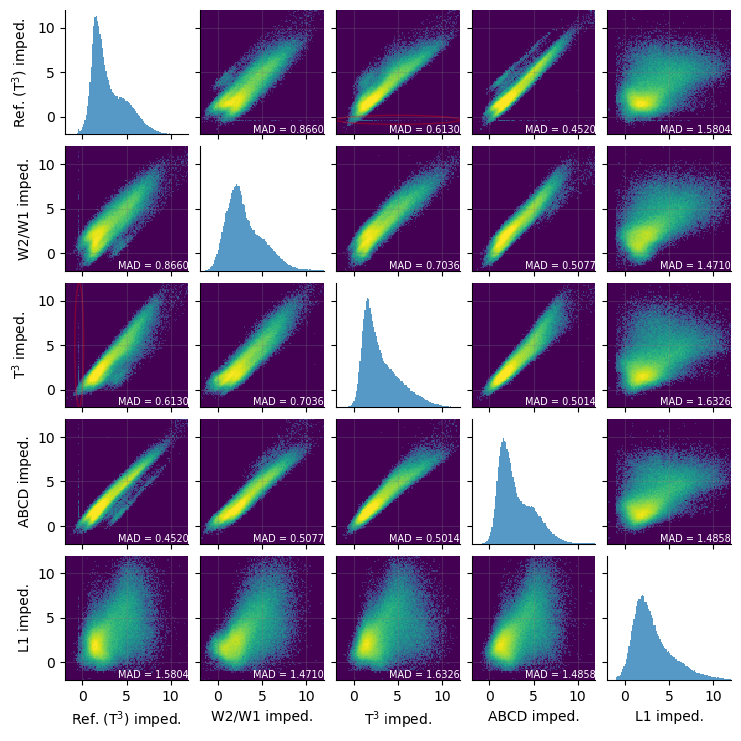

In [19]:
binrange = (-2, 12)

pairgrid = sns.PairGrid(df_impedance, height=1.5)
pairgrid.map_diag(sns.histplot, binrange=binrange, bins=100, edgecolor=None)
pairgrid.map_offdiag(pairgrid_hist2d, bins=100, range=(binrange, binrange), metric='mae',
                     norm=mpl.colors.LogNorm(), cmap='viridis')
pairgrid.set(xticks=[0, 5, 10], yticks=[0, 5, 10])

axes = pairgrid.figure.get_axes()
axes[ 2].add_artist(Ellipse(xy=[5, -0.35384], width=14, height=1, ec='red', fill=False, alpha=0.33))
axes[10].add_artist(Ellipse(xy=[-0.35384, 5], width=1, height=14, ec='red', fill=False, alpha=0.33))

pairgrid.tight_layout()

## Identify repeated values in the reference results

The pair plots show that the reference T3 implementation produces certain repeated values in both the thickness and the impedance. Let us identify these values.

In [20]:
from collections import Counter

impedance_counter = Counter([float(val.magnitude) for val in impedance_ref.array.flatten()])
thickness_counter = Counter([float(val.magnitude) for val in thickness_ref.array.flatten()])

In [21]:
n_waveforms = thickness_ref.array.size
threshold = 1e-4 * n_waveforms

print('Repeated thickness values:')
for val, num in thickness_counter.most_common():
    if num > threshold:
        print(f'{val:.5f} cm is repeated {num} times, representing {num/n_waveforms:.3%} of all values')
print()

print('Repeated impedance values:')
for val, num in impedance_counter.most_common():
    if num > threshold:
        print(f'{val:.5f} MRayl is repeated {num} times, representing {num/n_waveforms:.3%} of all values')
print()

Repeated thickness values:
1.36597 cm is repeated 137 times, representing 0.097% of all values
1.37876 cm is repeated 16 times, representing 0.011% of all values

Repeated impedance values:
16.69102 MRayl is repeated 316 times, representing 0.223% of all values
-0.35384 MRayl is repeated 190 times, representing 0.134% of all values
31.81628 MRayl is repeated 47 times, representing 0.033% of all values

